
# 1. OpenAI VLM (GPT-4*) - Basics
This section demonstrates the basic usage of OpenAI's Vision Language Model (VLM) capabilities using GPT-4.
We will use the OpenAI API to analyze an image and provide detailed textual insights.

**Support Material**:
- https://platform.openai.com/docs/guides/text-generation 
- https://platform.openai.com/docs/guides/vision?lang=node
- https://platform.openai.com/docs/guides/text-generation?text-generation-quickstart-example=image 
- https://platform.openai.com/docs/api-reference/chat


In [2]:
import openai
from dotenv import load_dotenv  
import os
import base64
import json
import textwrap

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')


load_dotenv()
#openAIclient = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))
openAIclient = openai.OpenAI(api_key= os.getenv("OPENAI_API_KEY"))




TEXTMODEL = "gpt-4o-mini" 
IMGMODEL= "gpt-4o-mini" 

# Path to your image
img = "images/street_scene.jpg"

In [3]:
#basic call to gpt4 with prompt and image

completion = openAIclient.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What's in this image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encode_image(img)}",
                        #"detail": "low"
                    }
                },
            ],
        }
    ],
)


# Wrap the text to a specified width

response = str(completion.choices[0].message)
print(textwrap.fill(response, width=120))


ChatCompletionMessage(content='The image depicts a bustling urban street scene. Key elements include:\n\n- A city
environment with tall buildings and shops.\n- People engaging in various activities: a boy sitting on the ground with a
device, a woman reading on a bench, and a man playing guitar.\n- A cyclist in motion, a person on a scooter, and
pedestrians crossing the street.\n- Pigeons scattered near a flower pot on the ground.\n- It appears to be a lively
moment captured in a city, possibly depicting the vibrancy of urban life.', role='assistant', function_call=None,
tool_calls=None, refusal=None)



# 1.1 Structured Output
Here, we expand upon the VLM example to request structured outputs. This approach allows for extracting 
well-organized information from images in a machine-readable format, such as JSON.

**Support Material**:
- https://platform.openai.com/docs/guides/text-generation?text-generation-quickstart-example=json


In [4]:
def promptLLM(prompt : str = None, sysprompt : str = None,  image : str = None, wantJson : bool = False, returnDict : bool = False):
    returnValue = ""
    messages = [{"role": "system", "content" : sysprompt}]
    modelToUse = TEXTMODEL
    #force it to be a json answer prompt
    #prompt = prompt if not wantJson else returnJSONAnswerPrompt(prompt)
    messages.append({"role": "user", "content": [{ 
        "type" : "text", 
        "text" : prompt 
    }]})
    if image is not None:
        image = f"data:image/jpeg;base64,{image}"
        messages[1]["content"].append({"type": "image_url", "image_url": { "url" : image}})
        modelToUse = IMGMODEL

    if wantJson:
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,
            #max_tokens= 400,
            response_format={ "type": "json_object" },
            messages=messages,
            temperature=0,
            #n=1,
        )
    else :
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,
            messages=messages,
            temperature=0,
            #n=1,
        )
    returnValue = returnValue.choices[0].message.content
    if returnDict:
        return json.loads(returnValue)
    return returnValue

In [5]:
output = promptLLM(prompt = "describe the image in detail",sysprompt = "you are a careful observer. the response should be in json format", image = encode_image(img), wantJson=True, returnDict=True)

In [6]:
output

{'description': {'scene': 'A bustling city street with a mix of pedestrians and vehicles.',
  'foreground': {'elements': [{'type': 'person',
     'action': 'sitting',
     'details': {'gender': 'male',
      'age': 'teen',
      'clothing': 'green jacket, shorts',
      'activity': 'using a smartphone',
      'position': 'on the ground'}},
    {'type': 'person',
     'action': 'lying down',
     'details': {'gender': 'male',
      'age': 'teen',
      'clothing': 'red hoodie',
      'position': 'on the ground, appearing unconscious'}},
    {'type': 'person',
     'action': 'sitting',
     'details': {'gender': 'female',
      'age': 'young adult',
      'clothing': 'red top, blue jeans',
      'activity': 'reading a book',
      'position': 'on a bench'}},
    {'type': 'person',
     'action': 'sitting',
     'details': {'gender': 'male',
      'age': 'older adult',
      'clothing': 'suit',
      'activity': 'reading a newspaper',
      'position': 'on a bench'}},
    {'type': 'person

In [7]:
output["description"]["foreground"]

{'elements': [{'type': 'person',
   'action': 'sitting',
   'details': {'gender': 'male',
    'age': 'teen',
    'clothing': 'green jacket, shorts',
    'activity': 'using a smartphone',
    'position': 'on the ground'}},
  {'type': 'person',
   'action': 'lying down',
   'details': {'gender': 'male',
    'age': 'teen',
    'clothing': 'red hoodie',
    'position': 'on the ground, appearing unconscious'}},
  {'type': 'person',
   'action': 'sitting',
   'details': {'gender': 'female',
    'age': 'young adult',
    'clothing': 'red top, blue jeans',
    'activity': 'reading a book',
    'position': 'on a bench'}},
  {'type': 'person',
   'action': 'sitting',
   'details': {'gender': 'male',
    'age': 'older adult',
    'clothing': 'suit',
    'activity': 'reading a newspaper',
    'position': 'on a bench'}},
  {'type': 'person',
   'action': 'walking',
   'details': {'gender': 'female',
    'age': 'young adult',
    'clothing': 'pink top, shorts',
    'activity': 'looking at her phone'


# JSON Schema for Controlled Structured Outputs
In this section, we define a JSON schema for a more controlled and specific output from the model. 
Using this schema, we can ensure the model adheres to predefined data types and structures while describing images.In this case we will provide an exmaple of json format answer, but ideally 
one could also do it via e.g. pydantic library.

Example: 
```
from typing import List, Literal
from pydantic import BaseModel, Field


class Person(BaseModel):
    position: str = Field(..., description="Position of the person in the environment, e.g., standing, sitting, etc.")
    age: int = Field(..., ge=0, description="Age of the person, must be a non-negative integer.")
    activity: str = Field(..., description="Activity the person is engaged in, e.g., reading, talking, etc.")
    gender: Literal["male", "female", "non-binary", "other", "prefer not to say"] = Field(
        ..., description="Gender of the person"
    )


class ImageExtraction(BaseModel):
    number_of_people: int = Field(..., ge=0, description="The total number of people in the environment.")
    atmosphere: str = Field(..., description="Description of the atmosphere, e.g., calm, lively, etc.")
    hour_of_the_day: int = Field(..., ge=0, le=23, description="The hour of the day in 24-hour format.")
    people: List[Person] = Field(..., description="List of people and their details.")

```

In [8]:
def promptLLM(prompt : str = None, sysprompt : str = None,  image : str = None, wantJson : bool = False, returnDict : bool = False):
    returnValue = ""
    messages = [{"role": "system", "content" : sysprompt}]
    modelToUse = TEXTMODEL
    #force it to be a json answer prompt
    #prompt = prompt if not wantJson else returnJSONAnswerPrompt(prompt)
    messages.append({"role": "user", "content": [{ 
        "type" : "text", 
        "text" : prompt 
    }]})
    if image is not None:
        image = f"data:image/jpeg;base64,{image}"
        messages[1]["content"].append({"type": "image_url", "image_url": { "url" : image}})
        modelToUse = IMGMODEL

    if wantJson:
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,
            #max_tokens= 400,
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "img_extract",
                    "schema": {
                    "type": "object",
                    "properties": {
                        "numberOfPeople": {
                        "type": "integer",
                        "description": "The total number of people in the environment",
                        "minimum": 0
                        },
                        "atmosphere": {
                        "type": "string",
                        "description": "Description of the atmosphere, e.g., calm, lively, etc."
                        },
                        "hourOfTheDay": {
                        "type": "integer",
                        "description": "The hour of the day in 24-hour format",
                        "minimum": 0,
                        "maximum": 23
                        },
                        "people": {
                        "type": "array",
                        "description": "List of people and their details",
                        "items": {
                            "type": "object",
                            "properties": {
                            "position": {
                                "type": "string",
                                "description": "Position of the person in the environment, e.g., standing, sitting, etc."
                            },
                            "age": {
                                "type": "integer",
                                "description": "Age of the person",
                                "minimum": 0
                            },
                            "activity": {
                                "type": "string",
                                "description": "Activity the person is engaged in, e.g., reading, talking, etc."
                            },
                            "gender": {
                                "type": "string",
                                "description": "Gender of the person",
                                "enum": ["male", "female", "non-binary", "other", "prefer not to say"]
                            }
                            },
                            "required": ["position", "age", "activity", "gender"]
                        }
                        }
                    },
                    "required": ["numberOfPeople", "atmosphere", "hourOfTheDay", "people"]
                    }}},
            messages=messages,
            temperature=0,
            #n=1,
        )
    else :
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,
            messages=messages,
            temperature=0,
            #n=1,
        )
    returnValue = returnValue.choices[0].message.content
    if returnDict:
        return json.loads(returnValue)
    return returnValue

In [9]:
output_image_analysis = promptLLM(prompt = "describe the image in detail",sysprompt = "you are a careful observer. the response should be in json format", image = encode_image(img), wantJson=True, returnDict=True)

In [10]:
#alert service prompt 

alert_sys_prompt = " you are an experienced first aid paramedical"
alert_prompt= """Extract from the following scene analysis give to you in json format, 
if anyone might be in danger and if the Child Hospital or normal Hospital should be alerted. 
Give the a concise answer
The situation is given to you from this object: """ + str(output_image_analysis)


In [11]:
promptLLM(prompt = alert_prompt, sysprompt= alert_sys_prompt) 

'In this scene, the 16-year-old male who is lying down and unconscious is in danger. The normal hospital should be alerted for this situation, as it indicates a potential medical emergency.'

In [12]:
promptLLM(prompt = "Considering the image analysis given" +str(output_image_analysis)+ "give me back the coordinates of the 16-years old. If these are not available, infer them form the pic", sysprompt= alert_sys_prompt) 

'Based on the provided information, there are no specific coordinates given for the individuals in the image. However, since the scenario describes a busy urban environment with various activities, we can infer that the 16-year-old male who is lying down and unconscious would likely be located in a more central area where people are gathered, possibly near a sidewalk or park bench.\n\nIn a busy urban setting, if we were to estimate coordinates, we might place the unconscious individual in a location that is easily accessible for emergency responders. For example, if we assume a grid layout for the area, we could suggest coordinates like (5, 5) or (10, 10) as a central point where the individual might be found.\n\nHowever, please note that these coordinates are purely hypothetical and should not be used for actual navigation or emergency response without proper visual confirmation. In a real-life scenario, it is crucial to assess the situation visually and ensure the safety of all indiv

In [13]:
promptLLM(prompt =  "Detect if there is a person who is under 18 years old on the floor and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.", sysprompt= alert_sys_prompt, image = encode_image(img)) 

'[400, 600, 500, 700]'


# 2. Google VLM (Gemini)
This section demonstrates the use of Google's Vision Language Model, Gemini. 
We explore basic text generation as well as its ability to analyze images and provide relevant outputs.

**Support Material**:
- https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing


In [14]:
%matplotlib inline
import os
from dotenv import load_dotenv  
import google.generativeai as genai
from PIL import Image

load_dotenv()
#genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("Explain how AI works")
print(response.text)


AI works by combining large amounts of data with fast, iterative processing and intelligent algorithms, allowing the software to learn automatically from patterns or features in the data.  There's no single "how it works" because different AI approaches use different techniques.  However, here's a breakdown of common principles:

**1. Data Acquisition and Preparation:**

* **Data Collection:** AI systems need massive datasets relevant to the task they're designed for. This data could be anything from images and text to sensor readings and financial transactions.
* **Data Cleaning and Preprocessing:**  Raw data is often messy and inconsistent. This stage involves removing errors, handling missing values, and transforming the data into a suitable format for the AI model.  This might include normalization, standardization, or feature extraction.

**2. Model Selection and Training:**

* **Algorithm Selection:**  The choice of algorithm depends on the type of problem being solved. Common ap

In [16]:
im = Image.open(img)

genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-pro")

response = model.generate_content([
    im,
    (
        "Detect if there is a person who is under 18 years old on the floor and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.\n "
    ),
])
response.resolve()
print(response.text)

[693,328,962,631]



Processing image: images/example_signature.jpg

OWL-ViT Detection Results:
[{'score': 0.549213707447052, 'label': 'a signature on paper', 'box': {'xmin': 9, 'ymin': 17, 'xmax': 3019, 'ymax': 4009}}, {'score': 0.10286667943000793, 'label': 'a handwritten signature', 'box': {'xmin': 1664, 'ymin': 2312, 'xmax': 2568, 'ymax': 2763}}]

Gemini Detection Results:
[558, 553, 859, 877]


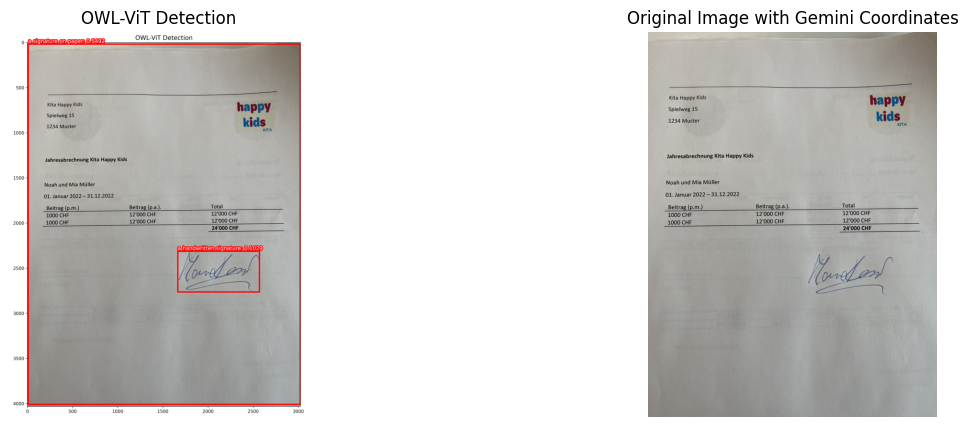

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from transformers import pipeline
import google.generativeai as genai
import os

def compare_detections(image_path):
    # 1. Bild laden
    image = Image.open(image_path)
    
    # 2. OWL-ViT Detektion
    def preprocess_outputs(output):
        input_scores = [x["score"] for x in output]
        input_labels = [x["label"] for x in output]
        input_boxes = []
        for i in range(len(output)):
            input_boxes.append([*output[i]["box"].values()])
        input_boxes = [input_boxes]
        return input_scores, input_labels, input_boxes

    def show_box(box, ax):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(
            plt.Rectangle((x0, y0), w, h, edgecolor="red", facecolor="none", lw=3)
        )

    def show_boxes_and_labels_on_image(raw_image, boxes, labels, scores, title):
        plt.figure(figsize=(15, 15))
        plt.imshow(raw_image)
        for i, box in enumerate(boxes):
            show_box(box, plt.gca())
            plt.text(
                x=box[0],
                y=box[1] - 12,
                s=f"{labels[i]}: {scores[i]:,.4f}",
                c="white",
                path_effects=[pe.withStroke(linewidth=4, foreground="red")],
                fontsize=12
            )
        plt.axis("on")
        plt.title(title, fontsize=14)
        plt.savefig(f'detected_objects_{title}.png', bbox_inches='tight', dpi=300)
        plt.close()

    # OWL-ViT Setup mit angepassten Labels für Signaturen
    OWL_checkpoint = "google/owlvit-base-patch32"
    text = [
        "a handwritten signature",
        "a signature on paper",
        "handwriting at bottom of document",
        "signed document"
    ]

    detector = pipeline(
        model=OWL_checkpoint,
        task="zero-shot-object-detection"
    )

    # OWL-ViT Detektion durchführen
    output_owl = detector(
        image,
        candidate_labels=text,
        threshold=0.1
    )

    print("\nOWL-ViT Detection Results:")
    print(output_owl)

    input_scores, input_labels, input_boxes = preprocess_outputs(output_owl)
    show_boxes_and_labels_on_image(
        image,
        input_boxes[0],
        input_labels,
        input_scores,
        "OWL-ViT Detection"
    )

    # 3. Gemini Detektion mit angepasstem Prompt für Signaturen
    genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
    model = genai.GenerativeModel("gemini-1.5-pro")

    response = model.generate_content([
        image,
        ("Detect if there is a handwritten signature on this document and return its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.\n")
    ])
    response.resolve()
    print("\nGemini Detection Results:")
    print(response.text)

    # 4. Ergebnisse visualisieren
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open('detected_objects_OWL-ViT Detection.png'))
    plt.title('OWL-ViT Detection')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.title('Original Image with Gemini Coordinates')
    plt.axis('off')
    plt.show()

# Funktion für verschiedene Bilder ausführen
image_paths = ["images/example_signature.jpg"]  # Pfad zu Ihrem Signaturbild
for img_path in image_paths:
    print(f"\nProcessing image: {img_path}")
    compare_detections(img_path)

Gemini can be used to predict bounding boxes based on free form text queries.
The model can be prompted to return the boxes in a variety of different formats (dictionary, list, etc). This of course migh need to be parsed. 
Check: https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing#scrollTo=WFLDgSztv77H
